In [1]:
# ✅ QGAN for Hair Removal - Paired Setting (Quality-aware GAN)
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from sewar.full_ref import uqi

# ----------------------- Dataset ----------------------- #
class HairRemovalDataset(Dataset):
    def __init__(self, image_dir, clean_dir, transform=None):
        self.image_dir = image_dir
        self.clean_dir = clean_dir
        self.image_list = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        hair_img = Image.open(os.path.join(self.image_dir, self.image_list[idx])).convert('RGB').resize((256, 256))
        clean_img = Image.open(os.path.join(self.clean_dir, self.image_list[idx])).convert('RGB').resize((256, 256))
        if self.transform:
            hair_img = self.transform(hair_img)
            clean_img = self.transform(clean_img)
        return hair_img, clean_img

# ----------------------- QGAN Generator (U-Net backbone) ----------------------- #
class QGANGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        def down_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 4, 2, 1),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(0.2, inplace=True)
            )

        def up_block(in_c, out_c):
            return nn.Sequential(
                nn.ConvTranspose2d(in_c, out_c, 4, 2, 1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )

        self.down1 = down_block(in_channels, 64)
        self.down2 = down_block(64, 128)
        self.down3 = down_block(128, 256)
        self.down4 = down_block(256, 512)

        self.middle = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(True)
        )

        self.up4 = up_block(512, 256)
        self.up3 = up_block(512, 128)
        self.up2 = up_block(256, 64)
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        m = self.middle(d4)
        u4 = self.up4(m)
        u3 = self.up3(torch.cat([u4, d3], 1))
        u2 = self.up2(torch.cat([u3, d2], 1))
        return self.up1(torch.cat([u2, d1], 1))

# ----------------------- QGAN Discriminator (PatchGAN) ----------------------- #
class QGANDiscriminator(nn.Module):
    def __init__(self, in_channels=6):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 1)
        )

    def forward(self, x, y):
        return self.model(torch.cat([x, y], dim=1))

# ----------------------- QGAN Quality Loss ----------------------- #
def quality_loss(pred, target):
    ssim = structural_similarity(
        pred.detach().cpu().numpy().transpose(1, 2, 0),
        target.detach().cpu().numpy().transpose(1, 2, 0),
        channel_axis=2, data_range=2.0
    )
    return 1 - ssim

100%|██████████| 38/38 [00:06<00:00,  5.49it/s]


Epoch 1: G Loss=5.4498, D Loss=0.5967


100%|██████████| 38/38 [00:06<00:00,  5.82it/s]


Epoch 2: G Loss=4.6075, D Loss=0.4956


100%|██████████| 38/38 [00:06<00:00,  5.72it/s]


Epoch 3: G Loss=4.7379, D Loss=0.3351


100%|██████████| 38/38 [00:06<00:00,  5.69it/s]


Epoch 4: G Loss=5.3180, D Loss=0.2011


100%|██████████| 38/38 [00:06<00:00,  5.71it/s]


Epoch 5: G Loss=5.8045, D Loss=0.1325


100%|██████████| 38/38 [00:06<00:00,  5.63it/s]


Epoch 6: G Loss=6.2310, D Loss=0.0966


100%|██████████| 38/38 [00:06<00:00,  5.73it/s]


Epoch 7: G Loss=6.4703, D Loss=0.0787


100%|██████████| 38/38 [00:06<00:00,  5.78it/s]


Epoch 8: G Loss=6.7399, D Loss=0.0488


100%|██████████| 38/38 [00:06<00:00,  5.72it/s]


Epoch 9: G Loss=6.8921, D Loss=0.0340


100%|██████████| 38/38 [00:06<00:00,  5.76it/s]


Epoch 10: G Loss=6.2310, D Loss=0.3469


100%|██████████| 38/38 [00:06<00:00,  5.73it/s]


Epoch 11: G Loss=6.0267, D Loss=0.1603


100%|██████████| 38/38 [00:06<00:00,  5.73it/s]


Epoch 12: G Loss=6.8519, D Loss=0.0519


100%|██████████| 38/38 [00:06<00:00,  5.73it/s]


Epoch 13: G Loss=7.1876, D Loss=0.0297


100%|██████████| 38/38 [00:06<00:00,  5.79it/s]


Epoch 14: G Loss=6.3584, D Loss=0.2713


100%|██████████| 38/38 [00:06<00:00,  5.79it/s]


Epoch 15: G Loss=6.7950, D Loss=0.0439


100%|██████████| 38/38 [00:06<00:00,  5.69it/s]


Epoch 16: G Loss=7.0998, D Loss=0.0415


100%|██████████| 38/38 [00:06<00:00,  5.62it/s]


Epoch 17: G Loss=7.8524, D Loss=0.0253


100%|██████████| 38/38 [00:06<00:00,  5.68it/s]


Epoch 18: G Loss=7.9556, D Loss=0.0164


100%|██████████| 38/38 [00:06<00:00,  5.64it/s]


Epoch 19: G Loss=7.3465, D Loss=0.0179


100%|██████████| 38/38 [00:06<00:00,  5.76it/s]


Epoch 20: G Loss=7.2565, D Loss=0.0160


100%|██████████| 38/38 [00:06<00:00,  5.85it/s]


Epoch 21: G Loss=8.2891, D Loss=0.0135


100%|██████████| 38/38 [00:06<00:00,  5.80it/s]


Epoch 22: G Loss=8.3626, D Loss=0.0169


100%|██████████| 38/38 [00:06<00:00,  5.72it/s]


Epoch 23: G Loss=8.7430, D Loss=0.0120


100%|██████████| 38/38 [00:06<00:00,  5.68it/s]


Epoch 24: G Loss=8.2415, D Loss=0.0110


100%|██████████| 38/38 [00:06<00:00,  5.73it/s]


Epoch 25: G Loss=7.9224, D Loss=0.0095


100%|██████████| 38/38 [00:06<00:00,  5.73it/s]


Epoch 26: G Loss=7.8853, D Loss=0.0079


100%|██████████| 38/38 [00:06<00:00,  5.77it/s]


Epoch 27: G Loss=8.3469, D Loss=0.0101


100%|██████████| 38/38 [00:06<00:00,  5.82it/s]


Epoch 28: G Loss=8.5015, D Loss=0.0069


100%|██████████| 38/38 [00:06<00:00,  5.78it/s]


Epoch 29: G Loss=8.4273, D Loss=0.0075


100%|██████████| 38/38 [00:06<00:00,  5.73it/s]


Epoch 30: G Loss=8.1266, D Loss=0.0070

=== QGAN Hair Removal Image Quality ===
MSE   : 0.008155
PSNR  : 22.12 dB
SSIM  : 0.4690
UQI   : 0.9782


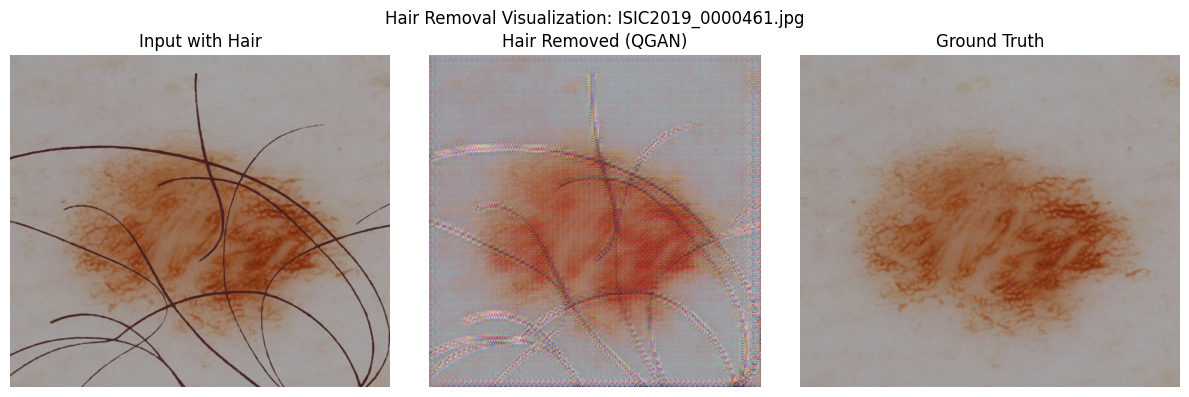

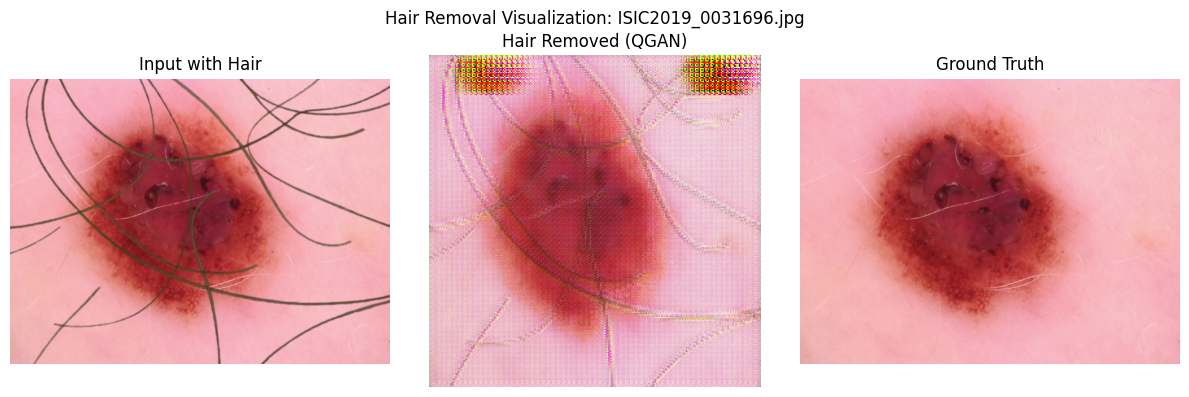

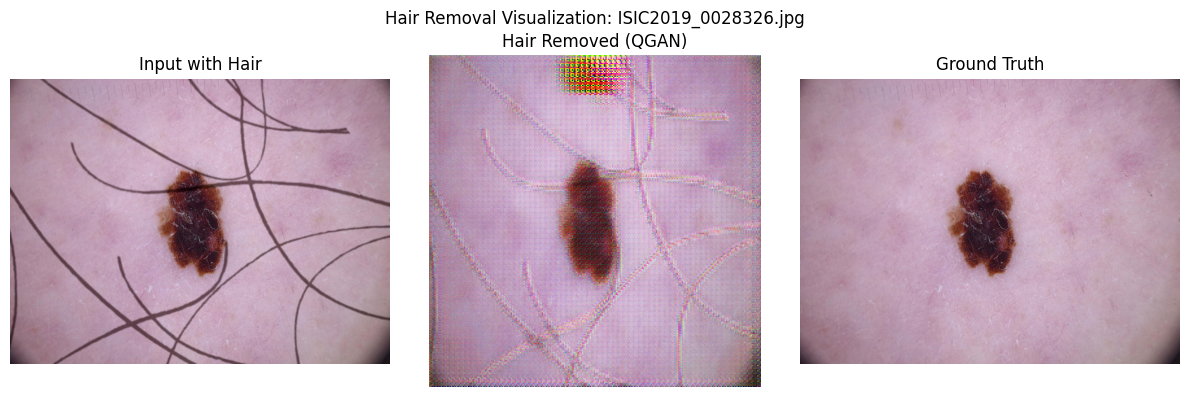

In [2]:
# ✅ QGAN for Hair Removal - Paired Setting (Quality-aware GAN)
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from sewar.full_ref import uqi

# ----------------------- Dataset ----------------------- #
class HairRemovalDataset(Dataset):
    def __init__(self, image_dir, clean_dir, transform=None):
        self.image_dir = image_dir
        self.clean_dir = clean_dir
        self.image_list = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        hair_img = Image.open(os.path.join(self.image_dir, self.image_list[idx])).convert('RGB').resize((256, 256))
        clean_img = Image.open(os.path.join(self.clean_dir, self.image_list[idx])).convert('RGB').resize((256, 256))
        if self.transform:
            hair_img = self.transform(hair_img)
            clean_img = self.transform(clean_img)
        return hair_img, clean_img

# ----------------------- QGAN Generator (U-Net backbone) ----------------------- #
class QGANGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        def down_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 4, 2, 1),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(0.2, inplace=True)
            )

        def up_block(in_c, out_c):
            return nn.Sequential(
                nn.ConvTranspose2d(in_c, out_c, 4, 2, 1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )

        self.down1 = down_block(in_channels, 64)
        self.down2 = down_block(64, 128)
        self.down3 = down_block(128, 256)
        self.down4 = down_block(256, 512)

        self.middle = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(True)
        )

        self.up4 = up_block(512, 256)
        self.up3 = up_block(512, 128)
        self.up2 = up_block(256, 64)
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        m = self.middle(d4)
        u4 = self.up4(m)
        u3 = self.up3(torch.cat([u4, d3], 1))
        u2 = self.up2(torch.cat([u3, d2], 1))
        return self.up1(torch.cat([u2, d1], 1))

# ----------------------- QGAN Discriminator (PatchGAN) ----------------------- #
class QGANDiscriminator(nn.Module):
    def __init__(self, in_channels=6):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 1)
        )

    def forward(self, x, y):
        return self.model(torch.cat([x, y], dim=1))

# ----------------------- Training, Evaluation, Visualization ----------------------- #
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = HairRemovalDataset(
    image_dir="/root/autodl-fs/skin_hair_dataset/alignment/photo with hair",
    clean_dir="/root/autodl-fs/skin_hair_dataset/alignment/oryginal",
    transform=transform
)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen = QGANGenerator().to(device)
disc = QGANDiscriminator().to(device)

opt_G = torch.optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.999))

bce_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

def quality_loss(pred, target):
    pred_np = pred.detach().cpu().numpy().transpose(1, 2, 0)
    target_np = target.detach().cpu().numpy().transpose(1, 2, 0)
    ssim = structural_similarity(pred_np, target_np, channel_axis=2, data_range=2.0)
    return 1 - ssim

# Train
for epoch in range(30):
    gen.train(); disc.train()
    g_total, d_total = 0, 0
    for hair, clean in tqdm(loader):
        hair, clean = hair.to(device), clean.to(device)
        fake = gen(hair)

        # D
        real_out = disc(hair, clean)
        fake_out = disc(hair, fake.detach())
        d_loss = (bce_loss(real_out, torch.ones_like(real_out)) + bce_loss(fake_out, torch.zeros_like(fake_out))) / 2
        opt_D.zero_grad(); d_loss.backward(); opt_D.step()

        # G
        fake_out = disc(hair, fake)
        g_gan = bce_loss(fake_out, torch.ones_like(fake_out))
        g_l1 = l1_loss(fake, clean)
        g_quality = torch.tensor([quality_loss(f, c) for f, c in zip(fake, clean)]).mean().to(device)
        g_loss = g_gan + 10 * g_l1 + g_quality

        opt_G.zero_grad(); g_loss.backward(); opt_G.step()

        g_total += g_loss.item(); d_total += d_loss.item()

    print(f"Epoch {epoch+1}: G Loss={g_total/len(loader):.4f}, D Loss={d_total/len(loader):.4f}")

# Save final model
torch.save(gen.state_dict(), "qgan_gen_final.pth")

# Inference
@torch.no_grad()
def remove_hair(image_path, model, device):
    model.eval()
    image = Image.open(image_path).convert('RGB').resize((256, 256))
    input_tensor = transform(image).unsqueeze(0).to(device)
    output = model(input_tensor).squeeze(0).cpu()
    output = (output * 0.5 + 0.5).clamp(0, 1)
    return image, transforms.ToPILImage()(output)

# Evaluation & Visualization
image_dir = "/root/autodl-fs/skin_hair_dataset/alignment/photo with hair"
gt_dir = "/root/autodl-fs/skin_hair_dataset/alignment/oryginal"
image_names = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

mse_list, psnr_list, ssim_list, uqi_list = [], [], [], []

for name in image_names:
    input_path = os.path.join(image_dir, name)
    gt_path = os.path.join(gt_dir, name)
    if not os.path.exists(gt_path):
        continue
    gt_img = Image.open(gt_path).convert("RGB")
    _, pred_img = remove_hair(input_path, gen, device)

    # Metrics
    gt_arr = np.array(gt_img.resize((256, 256))).astype(np.float32) / 255.0
    pred_arr = np.array(pred_img.resize((256, 256))).astype(np.float32) / 255.0
    mse = mean_squared_error(gt_arr, pred_arr)
    psnr = peak_signal_noise_ratio(gt_arr, pred_arr, data_range=1.0)
    ssim = structural_similarity(gt_arr, pred_arr, channel_axis=2, data_range=1.0)
    uqi_val = uqi((gt_arr*255).astype(np.uint8), (pred_arr*255).astype(np.uint8))

    mse_list.append(mse)
    psnr_list.append(psnr)
    ssim_list.append(ssim)
    uqi_list.append(uqi_val)

print("\n=== QGAN Hair Removal Image Quality ===")
print(f"MSE   : {np.mean(mse_list):.6f}")
print(f"PSNR  : {np.mean(psnr_list):.2f} dB")
print(f"SSIM  : {np.mean(ssim_list):.4f}")
print(f"UQI   : {np.mean(uqi_list):.4f}")

# Visualization
visual_names = ["ISIC2019_0000461.jpg", "ISIC2019_0031696.jpg", "ISIC2019_0028326.jpg"]
for name in visual_names:
    input_path = os.path.join(image_dir, name)
    gt_path = os.path.join(gt_dir, name)
    input_img = Image.open(input_path).convert("RGB")
    gt_img = Image.open(gt_path).convert("RGB")
    _, pred_img = remove_hair(input_path, gen, device)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(input_img)
    plt.title("Input with Hair")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(pred_img)
    plt.title("Hair Removed (QGAN)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(gt_img)
    plt.title("Ground Truth")
    plt.axis("off")

    plt.suptitle(f"Hair Removal Visualization: {name}")
    plt.tight_layout()
    plt.show()
